In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
from scipy import stats
from functools import partial
from numba import njit


sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.diagnostics import true_vs_estimated

In [3]:
def kl_latent_space(z, log_det_J):
    """ Computes the Kullback-Leibler divergence (Maximum Likelihood Loss) between true and approximate
    posterior using simulated data and parameters.
    """

    loss = tf.reduce_mean(0.5 * tf.square(tf.norm(z, axis=-1)) - log_det_J)
    return loss

def maximum_mean_discrepancy(source_samples, target_samples, minimum=0.):
    """ This Maximum Mean Discrepancy (MMD) loss is calculated with a number of different Gaussian kernels.

    """

    sigmas = [
        1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100,
        1e3, 1e4, 1e5, 1e6
    ]
    gaussian_kernel = partial(_gaussian_kernel_matrix, sigmas=sigmas)
    loss_value = _mmd_kernel(source_samples, target_samples, kernel=gaussian_kernel)
    loss_value = tf.maximum(minimum, loss_value) 
    return loss_value

def _gaussian_kernel_matrix(x, y, sigmas):
    """ Computes a Gaussian Radial Basis Kernel between the samples of x and y.

    We create a sum of multiple gaussian kernels each having a width :math:`\sigma_i`.

    Parameters
    ----------
    x :  tf.Tensor of shape (M, num_features)
    y :  tf.Tensor of shape (N, num_features)
    sigmas : list(float)
        List which denotes the widths of each of the gaussians in the kernel.

    Returns
    -------
    kernel: tf.Tensor
        RBF kernel of shape [num_samples{x}, num_samples{y}]
    """
    def norm(v):
        return tf.reduce_sum(tf.square(v), 1)
    beta = 1. / (2. * (tf.expand_dims(sigmas, 1)))
    dist = tf.transpose(norm(tf.expand_dims(x, 2) - tf.transpose(y)))
    s = tf.matmul(beta, tf.reshape(dist, (1, -1)))
    kernel = tf.reshape(tf.reduce_sum(tf.exp(-s), 0), tf.shape(dist))
    return kernel

def _mmd_kernel(x, y, kernel=_gaussian_kernel_matrix):
    """ Computes the Maximum Mean Discrepancy (MMD) of two samples: x and y.

    Maximum Mean Discrepancy (MMD) is a distance-measure between the samples of the distributions of x and y.

    Parameters
    ----------
    x      : tf.Tensor of shape (num_samples, num_features)
    y      : tf.Tensor of shape (num_samples, num_features)
    kernel : callable, default: _gaussian_kernel_matrix
        A function which computes the kernel in MMD.

    Returns
    -------
    loss : tf.Tensor
        squared maximum mean discrepancy loss, shape (,)
    """

    loss = tf.reduce_mean(kernel(x, x))  # lint error: sigmas unfilled
    loss += tf.reduce_mean(kernel(y, y))  # lint error: sigmas unfilled
    loss -= 2 * tf.reduce_mean(kernel(x, y))  # lint error: sigmas unfilled
    return loss

def mmd_kl_loss(network, *args, mmd_weight=1.0):
    """KL loss in latent z space, MMD loss in summary space."""
    
    # Apply net and unpack 
    x_sum, out = network(*args, return_summary=True)
    z, log_det_J = out
    
    # Apply MMD loss to x_sum
    z_normal = tf.random.normal(x_sum.shape)
    mmd_loss = maximum_mean_discrepancy(x_sum, z_normal)
    
    # Apply KL loss for inference net
    kl_loss = kl_latent_space(z, log_det_J)
    
    # Sum and return losses
    return kl_loss + mmd_weight * mmd_loss

In [4]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # v_c ~ U(-7.0, 7.0)
    # a_c ~ U(0.1, 4.0)
    # t0 ~ U(0.1, 3.0)
    p_samples = np.random.uniform(low=(0.1, 0.1, 0.1, 0.1, 0.1),
                                  high=(7.0, 7.0, 4.0, 4.0, 3.0), size=(batch_size, 5))
    return p_samples.astype(np.float32)


@njit
def diffusion_trial(v, a, ndt, zr, dt, max_steps):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    x = a * zr

    # Simulate a single DM path
    while (x > 0 and x < a and n_steps < max_steps):

        # DDM equation
        x += v*dt + np.sqrt(dt) * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt
    return rt + ndt if x > 0. else -rt - ndt

@njit
def diffusion_condition(n_trials, v, a, ndt, zr=0.5, dt=0.005, max_steps=1e4):
    """Simulates a diffusion process over an entire condition."""

    x = np.empty(n_trials)
    for i in range(n_trials):
        x[i] = diffusion_trial(v, a, ndt, zr, dt, max_steps)
    return x


@njit
def diffusion_2_conds(params, n_trials, dt=0.005, max_steps=1e4):
    """
    Simulates a diffusion process for 2 conditions with 5 parameters (v1, v2, a1, a2, ndt).
    """

    n_trials_c1 = n_trials[0]
    n_trials_c2 = n_trials[1]

    v1, v2, a1, a2, ndt = params
    rt_c1 = diffusion_condition(n_trials_c1, v1, a1, ndt,  dt=dt, max_steps=max_steps)
    rt_c2 = diffusion_condition(n_trials_c2, v2, a2, ndt, dt=dt, max_steps=max_steps)
    rts = np.concatenate((rt_c1, rt_c2))
    return rts


def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0, max_iter=1e4):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_data = np.empty((n_sim, n_obs), dtype=np.float32)

    n1 = n_obs//2
    n2 = n_obs - n1

    # Simulate diffusion data
    for i in range(n_sim):
        sim_data[i] = diffusion_2_conds(prior_samples[i], (n1, n2))

    # Create condition labels
    cond_arr = np.stack(n_sim * [np.concatenate((np.zeros(n1), np.ones(n2)))] )
    sim_data = np.stack((sim_data, cond_arr), axis=-1)

    return sim_data

In [6]:
D = 5  # 5 parameters in total

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 64},
    'dense_s2_args': {'activation': 'relu', 'units': 64},
    'dense_s3_args': {'activation': 'relu', 'units': 64},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=D*2,  # twice the required
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 5,
    'alpha': 1.9,
    'permute': True
}


inference_net = InvertibleNetwork(inference_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0001,
                      checkpoint_path='export_ckpt/mmd/ddm',
                      max_to_keep = 2
                     )

Initializing networks from scratch.


In [13]:
losses = trainer.train_online(epochs=50, iterations_per_epoch=1000, batch_size=32, n_obs=100)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/1000 [00:00<?, ?it/s]

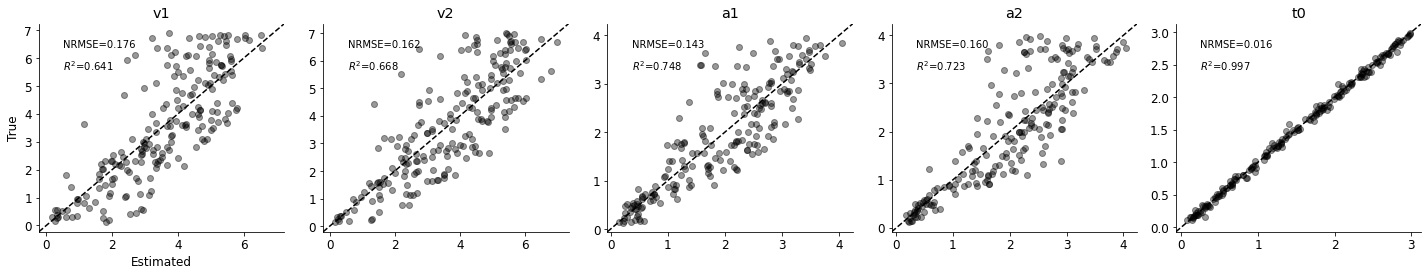

In [15]:
# Validate (quick and dirty)
p, x = trainer._forward_inference(200, 100)
param_samples = trainer.network.sample(x, n_samples=200)
param_means = param_samples.mean(axis=0)
true_vs_estimated(p, param_means, ['v1', 'v2', 'a1', 'a2', 't0'], figsize=(20,4))

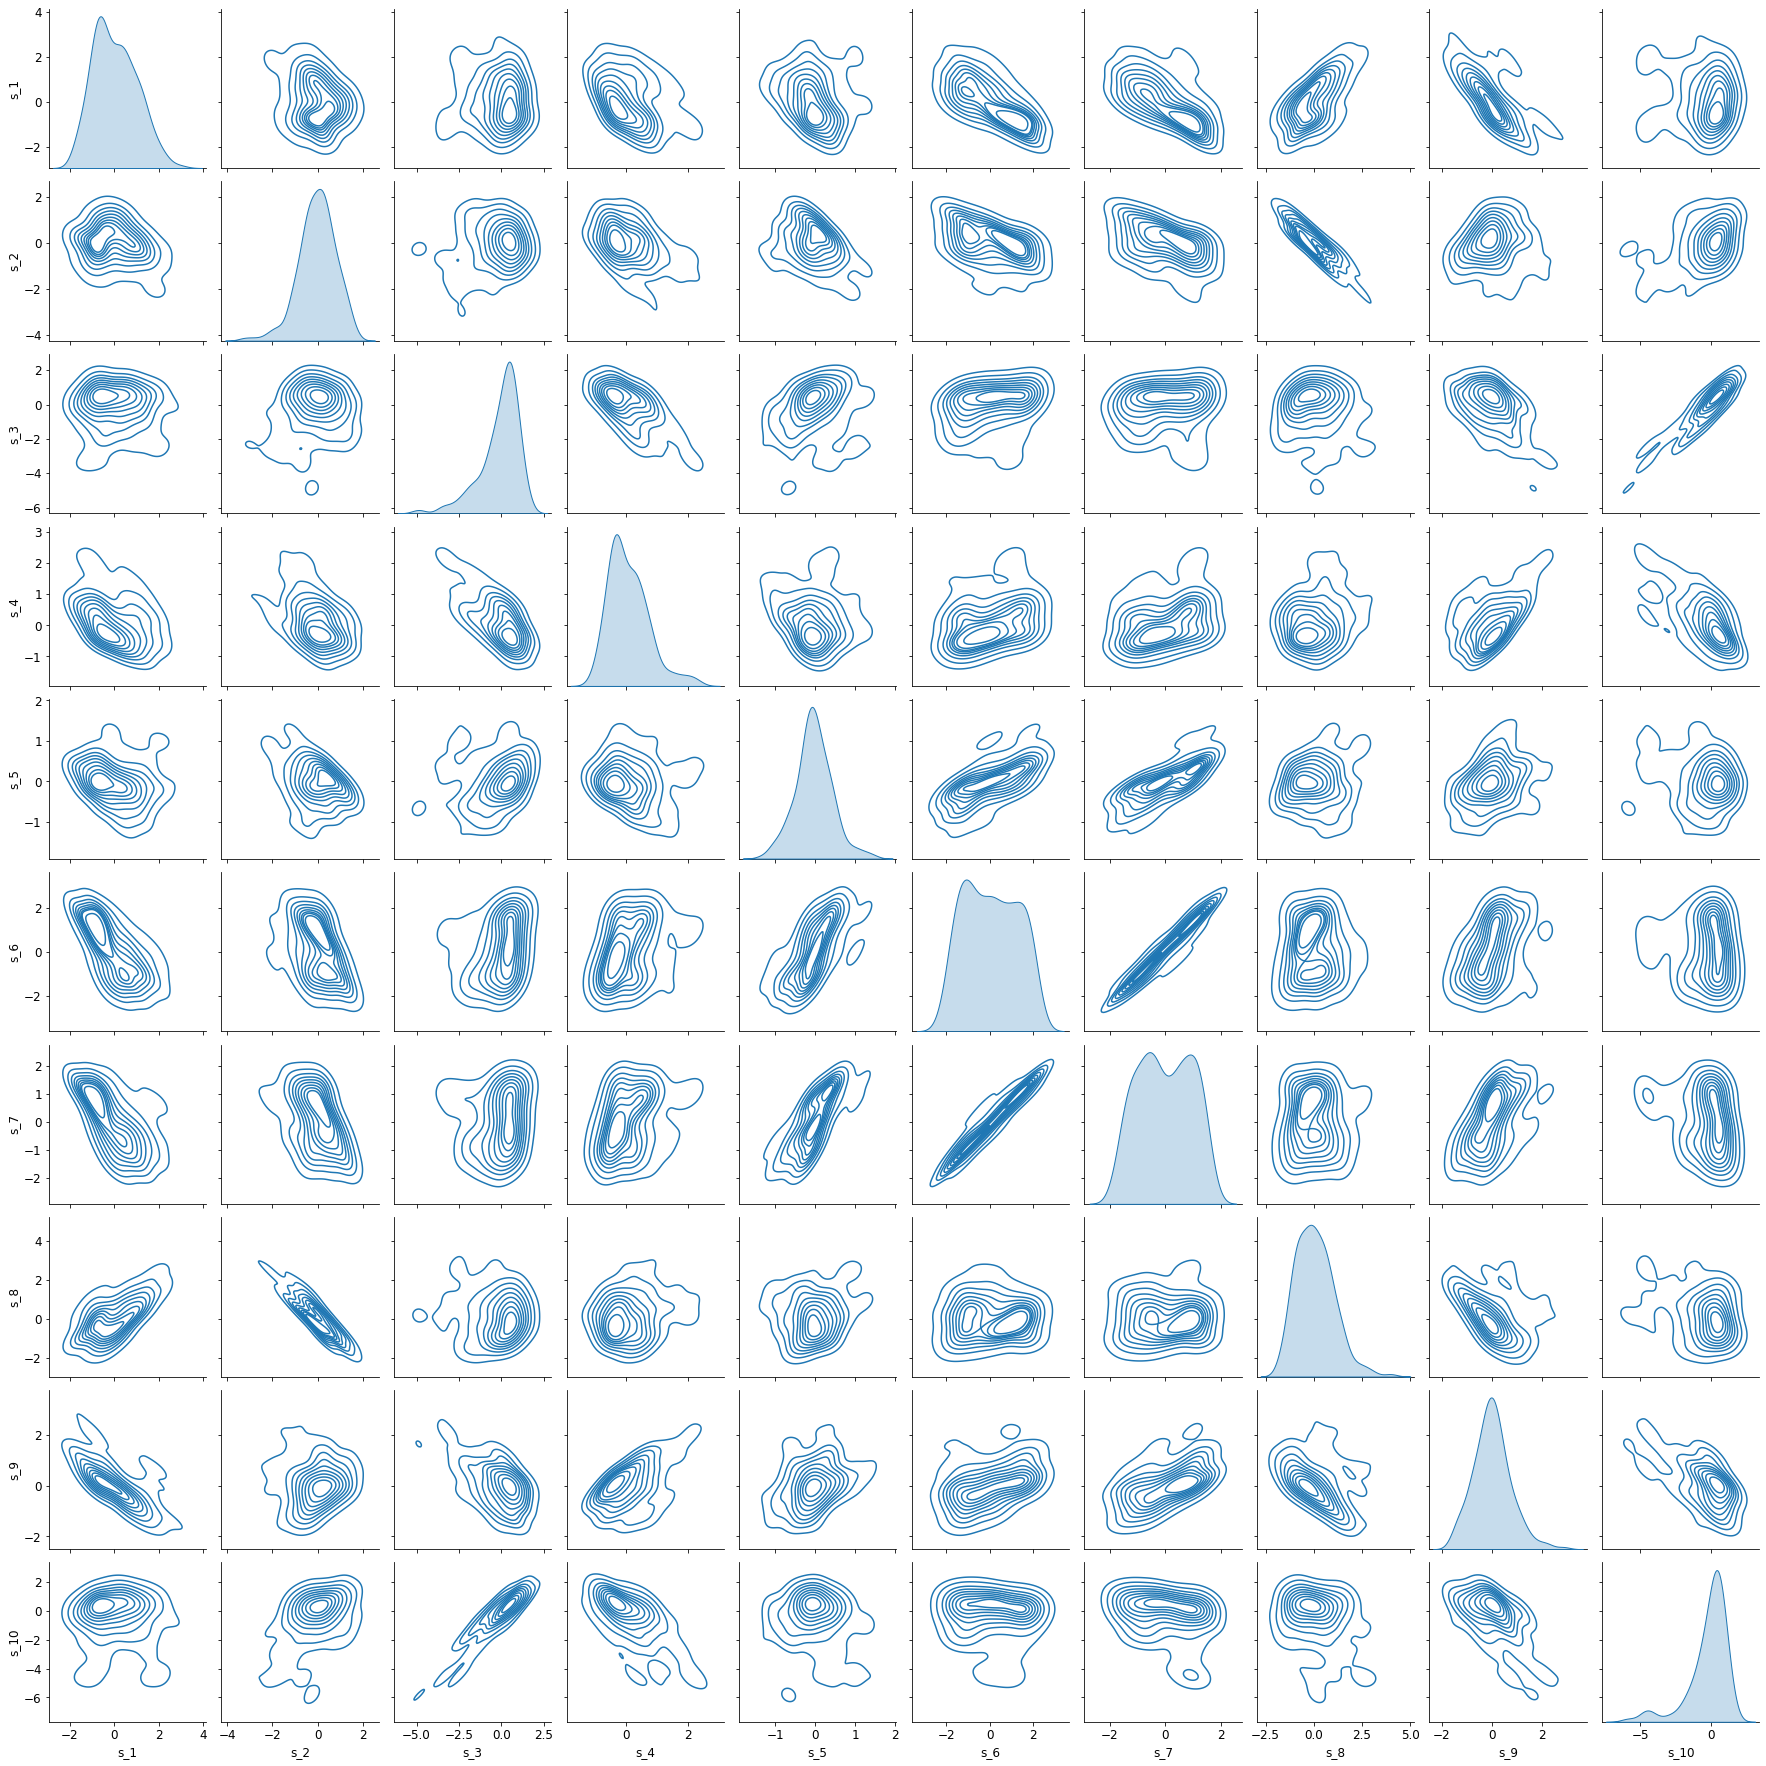

In [16]:
s = np.array(trainer.network.summary_net(x))
sns.pairplot(pd.DataFrame(s, columns=['s_{}'.format(i) for i in range(1, s.shape[1]+1)]), kind="kde")